<a href="https://colab.research.google.com/github/vicentcamison/idal_ia3/blob/main/3%20Aprendizaje%20profundo%20(II)/InfoGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset, Dataset
from torch import nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

import glob

from itertools import chain

We are going to create a GAN to generate new fonts

In [2]:
# Access to the BOB ROSS images folder
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#directory = "gdrive/MyDrive/UNIVERSIDAD/Master Propio IA UV/3 Aprendizaje profundo (II)/Datasets/Bob Ross/train"
directory = "gdrive/MyDrive/UNIVERSIDAD/Master Propio IA UV/3 Aprendizaje profundo (II)/Trabajo final/fonts"

In [4]:
# get data file names (this code takes a while to retrieve all data and prepare all dataframes)
filenames = glob.glob(directory + "/*.csv")
dfs = [pd.read_csv(filename) for filename in filenames]

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [6]:
# Characters have an index associated to them (m_label). The index is related to the character in the following dictionary
index_to_char = {65:'A', 66:'B', 67:'C', 68:'D', 69:'E', 70:'F', 71:'G', 72:'H', 73:'I', 74:'J',
                 75:'K', 76:'L', 77:'M', 78:'N', 79:'O', 80:'P', 81:'Q', 82:'R', 83:'S', 84:'T',
                 85:'U', 86:'V', 87:'W', 88:'X', 89:'Y', 90:'Z', 97:'a', 98:'b', 99:'c', 100:'d',
                 101:'e', 102:'f', 103:'g', 104:'h', 105:'i', 106:'j', 107:'k', 108:'l', 109:'m',
                 110:'n', 111:'o', 112:'p', 113:'q', 114:'r', 115:'s', 116:'t', 117:'u', 118:'v',
                 119:'w', 120:'x', 121:'y', 122:'z', 48:'0', 49:'1', 50:'2', 51:'3', 52:'4', 53:'5',
                 54:'6', 55:'7', 56:'8', 57:'9'}

In [7]:
number_min = 48
number_max = 57
upper_min = 65
upper_max = 90
lower_min = 97
lower_max = 122

In [8]:
# We create the datasets. We are going to divide them in NUMBERS, UPPERCASE LETTERS and LOWERCASE LETTERS
X_numbers = np.array([], ndmin=3)
X_upper = np.array([], ndmin=3)
X_lower = np.array([], ndmin=3)
Y_numbers = np.array([], ndmin=2)
Y_upper = np.array([], ndmin=2)
Y_lower = np.array([], ndmin=2)

i = 0
for df in dfs:
  #df = df[np.logical_and(df.loc[:,'strength'] < 0.5, df.loc[:,'italic'] == 0]
  df_straight = df[np.logical_and(df.loc[:,'strength'] < 0.5, df.loc[:,'italic'] == 0)] #remove the columns that are in bold or cursive
  #BY SLIGHTLY MODIFYING THIS LINE OF CODE AND ADDING THE CORRESPONDING LABELS TO Y, CURSIVE AND BOLD CAN BE ADDED TO THE MODEL

  # We get the elements of the dataframe that reference the images of characters (upper and lower letters, and numbers)
  X_numbers_new = df_straight[np.logical_and(df_straight.loc[:,'m_label'] >= number_min, df_straight.loc[:, 'm_label'] <= number_max)].iloc[:, 12:]
  X_upper_new = df_straight[np.logical_and(df_straight.loc[:,'m_label'] >= upper_min, df_straight.loc[:, 'm_label'] <= upper_max)].iloc[:, 12:]
  X_lower_new = df_straight[np.logical_and(df_straight.loc[:,'m_label'] >= lower_min, df_straight.loc[:, 'm_label'] <= lower_max)].iloc[:, 12:]

  Y_numbers_new = df_straight[np.logical_and(df_straight.loc[:,'m_label'] >= number_min, df_straight.loc[:, 'm_label'] <= number_max)].loc[:, ['m_label', 'font']]
  Y_upper_new = df_straight[np.logical_and(df_straight.loc[:,'m_label'] >= upper_min, df_straight.loc[:, 'm_label'] <= upper_max)].loc[:, ['m_label', 'font']]
  Y_lower_new = df_straight[np.logical_and(df_straight.loc[:,'m_label'] >= lower_min, df_straight.loc[:, 'm_label'] <= lower_max)].loc[:, ['m_label', 'font']]

  # We transform each element from a 400x1 array into a 20x20 array
  #X_numbers_new = np.reshape(X_numbers_new.values, (20,20,-1))
  #X_upper_new = np.reshape(X_upper_new.values, (20,20,-1))
  #X_lower_new = np.reshape(X_lower_new.values, (20,20,-1))

  # We rearrange the indexes so that the first index refers to image index
  #X_numbers_new = np.transpose(X_numbers_new, axes=[2, 0, 1])
  #X_upper_new = np.transpose(X_upper_new, axes=[2, 0, 1])
  #X_lower_new = np.transpose(X_lower_new, axes=[2, 0, 1])

  X_numbers_new = np.array(np.reshape(X_numbers_new.values, (-1,20,20)))
  X_upper_new = np.array(np.reshape(X_upper_new.values, (-1,20,20)))
  X_lower_new = np.array(np.reshape(X_lower_new.values, (-1,20,20)))

  X_numbers_new = X_numbers_new.astype('float64')
  X_upper_new = X_upper_new.astype('float64')
  X_lower_new = X_lower_new.astype('float64')

  # We append the _new vectors to the standard vectors
  if i == 0: # IS THERE A WAY TO PROGRAM THIS BETTER?
    X_numbers = X_numbers_new
    X_upper = X_upper_new
    X_lower = X_lower_new

    Y_numbers = Y_numbers_new
    Y_upper = Y_upper_new
    Y_lower = Y_lower_new

  else:
    X_numbers = np.concatenate((X_numbers, X_numbers_new), axis=0)
    X_upper = np.concatenate((X_upper, X_upper_new), axis=0)
    X_lower = np.concatenate((X_lower, X_lower_new), axis=0)

    Y_numbers = pd.concat([Y_numbers, Y_numbers_new], axis=0)
    Y_upper = pd.concat([Y_upper, Y_upper_new], axis=0)
    Y_lower = pd.concat([Y_lower, Y_lower_new], axis=0)

    #Y_numbers = np.concatenate((Y_numbers, np.array(Y_numbers_new)), axis=0)
    #Y_upper = np.concatenate((Y_upper, np.array(Y_upper_new)), axis=0)
    #Y_lower = np.concatenate((Y_lower, np.array(Y_lower_new)), axis=0)

    
  #X_numbers.append(X_numbers_new)
  #X_upper.append(X_upper_new)
  #X_lower.append(X_lower)

  #Y_numbers.append(Y_numbers_new)
  #Y_upper.append(Y_upper_new)
  #Y_lower.append(Y_lower_new)
  
  i += 1
  print(str(i)+'/'+str(len(dfs)))

  #for row in df[np.logical_and(df.loc[:,'strength'] < 0.5, df.loc[:,'italic'] == 0].iterrows():
   # if row.strength < 0.5 and row.italic == 0:

1/153
2/153
3/153
4/153
5/153
6/153
7/153
8/153
9/153
10/153
11/153
12/153
13/153
14/153
15/153
16/153
17/153
18/153
19/153
20/153
21/153
22/153
23/153
24/153
25/153
26/153
27/153
28/153
29/153
30/153
31/153
32/153
33/153
34/153
35/153
36/153
37/153
38/153
39/153
40/153
41/153
42/153
43/153
44/153
45/153
46/153
47/153
48/153
49/153
50/153
51/153
52/153
53/153
54/153
55/153
56/153
57/153
58/153
59/153
60/153
61/153
62/153
63/153
64/153
65/153
66/153
67/153
68/153
69/153
70/153
71/153
72/153
73/153
74/153
75/153
76/153
77/153
78/153
79/153
80/153
81/153
82/153
83/153
84/153
85/153
86/153
87/153
88/153
89/153
90/153
91/153
92/153
93/153
94/153
95/153
96/153
97/153
98/153
99/153
100/153
101/153
102/153
103/153
104/153
105/153
106/153
107/153
108/153
109/153
110/153
111/153
112/153
113/153
114/153
115/153
116/153
117/153
118/153
119/153
120/153
121/153
122/153
123/153
124/153
125/153
126/153
127/153
128/153
129/153
130/153
131/153
132/153
133/153
134/153
135/153
136/153
137/153
138/153
139/

In [ ]:
#THIS CODE IS NOW RENDERED UNNECESSARY

#print('finish0')
#X_numbers = np.concatenate(X_numbers, axis=0)
##print('finish1')
#X_upper = np.concatenate(X_upper, axis=0)
#print('finish2')
#X_lower = np.concatenate(X_lower, axis=0)
#print('finish3')

#Y_numbers = np.concatenate(Y_numbers, axis=0)
#print('finish4')
#Y_upper = np.concatenate(Y_upper, axis=0)
#print('finish5')
#Y_lower = np.concatenate(Y_lower, axis=0)
#print('finish6')

finish0


In [9]:
# We create a custom transform that can escale the images to [-1, 1] the range that's typically used
# in GANs. It's the image of the function tanh(), used sometimes as the last activation function
# in generators

class ToTanh(object):
    """Convert single-channel images from range [0, 256] to range [-1, 1]."""

    def __call__(self, pic):
        return torch.tensor(pic * 2 - 1, dtype=torch.float)

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [10]:
# Generation of the transform for the DataLoader
transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(0.5, 0.5)
  #ToTanh()
])

In [ ]:
#Append the Y columns at the end of the X columns

#X_numbers = np.concatenate([X_numbers, Y_numbers], axis=1)
#X_upper = np.concatenate([X_upper, Y_upper], axis=1)
#X_lower = np.concatenate([])

In [11]:
#We modify the dataset class to fit our needs: deliver an image and a label per example
class FontsDataset(Dataset):

    def __init__(self, X_images, Y_labels, transform=None):
        """
        Args:
            X_images (np.array): np.array containing all the font images
            Y_labels (np.array): np.array containing all the font labels
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.X_images = X_images
        #self.X_images.type(torch.FloatTensor)
        #for now, we only want to keep the column that indicates the character
        self.Y_labels = Y_labels.iloc[:,0]
        #we also apply one-hot encoding to the labels.
        #USE EMBEDDING FOR BIGGER COLLECTIONS OF CHARACTERS
        self.Y_labels = np.array(pd.get_dummies(Y_labels))
        self.transform = transform

    def __len__(self):
        return len(self.Y_labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        #img_name = os.path.join(self.root_dir,
        #                        self.landmarks_frame.iloc[idx, 0])
        #image = io.imread(img_name)
        #landmarks = self.landmarks_frame.iloc[idx, 1:]
        #landmarks = np.array([landmarks])
        #landmarks = landmarks.astype('float').reshape(-1, 2)
        #sample = {'image': image, 'landmarks': landmarks}

        image = self.X_images[idx]
        label = self.Y_labels[idx]

        if self.transform:
            image = self.transform(image)
            image.type(torch.FloatTensor)

        return image, label

In [12]:
type(X_numbers[0,0,0])

numpy.float64

In [13]:
numbers_dataset = FontsDataset(X_numbers, Y_numbers, transform)
upper_dataset = FontsDataset(X_upper, Y_upper, transform)
lower_dataset = FontsDataset(X_lower, Y_lower, transform)

batch_size = 32 #THIS NUMBER MAY BE INTERESTING TO PUT IT AT THE BEGINNING OF THE CODE

numbers_loader = DataLoader(numbers_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
upper_loader = DataLoader(upper_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
lower_loader = DataLoader(lower_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

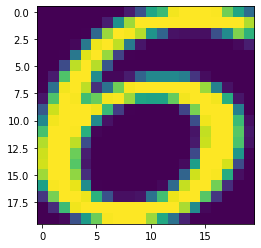

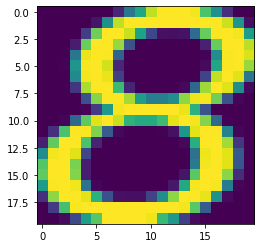

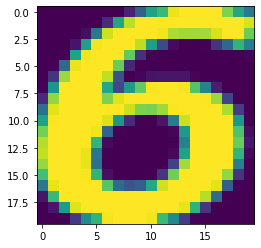

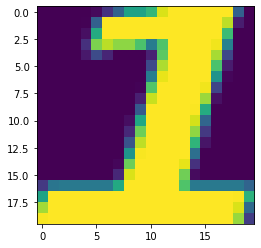

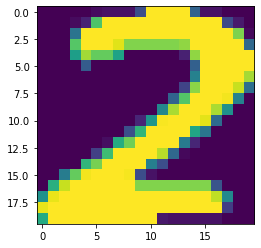

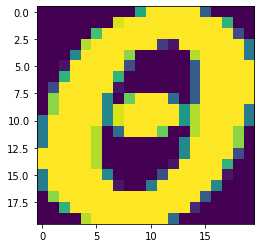

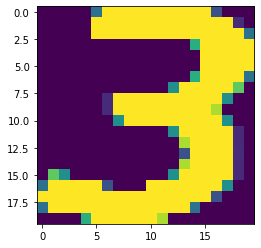

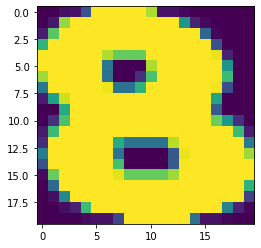

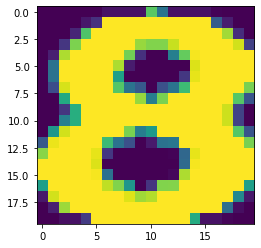

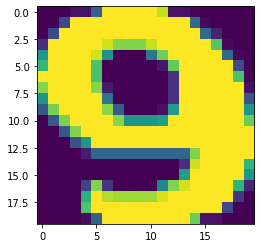

In [ ]:
#FUNCIÓN PARA PROBAR COSAS
# SE IRÁ DEL CÓDIGO EVENTUALMENTE

index = 21

plt.figure()
for i in np.arange(index, index+10):
  plt.imshow(X_numbers[i])
  plt.show()

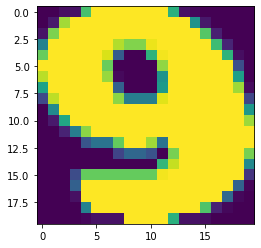

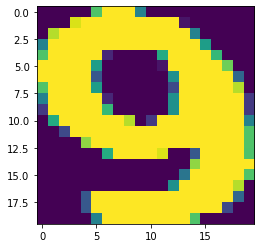

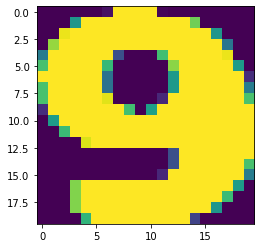

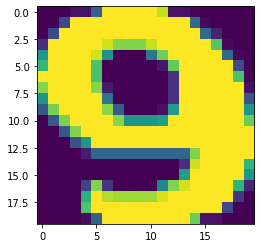

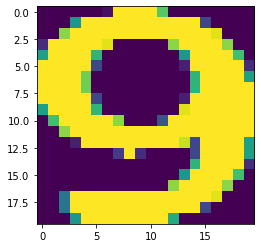

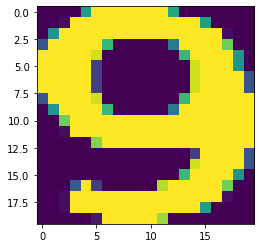

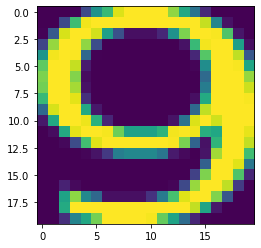

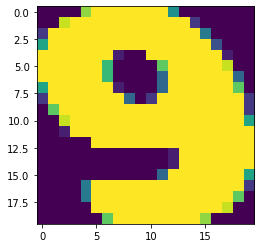

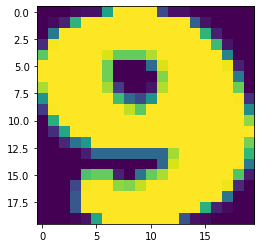

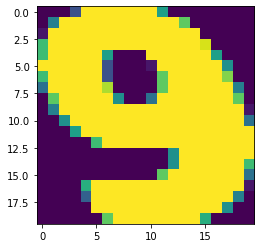

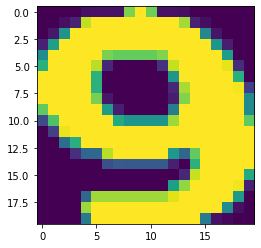

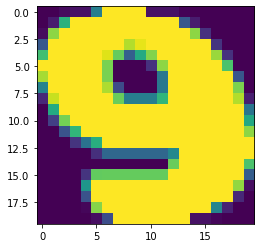

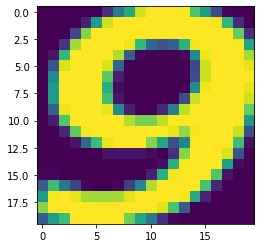

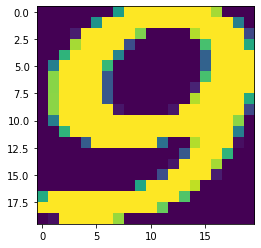

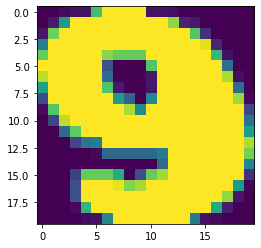

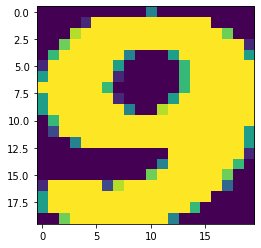

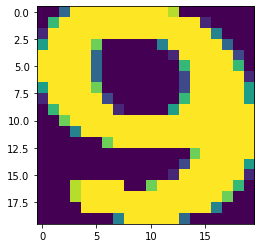

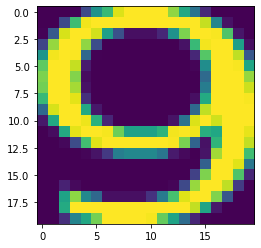

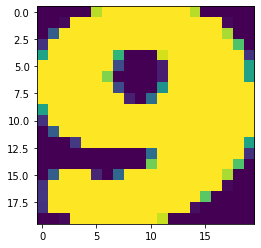

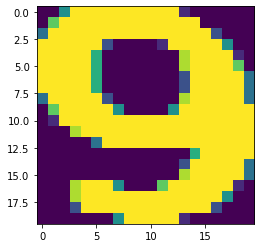

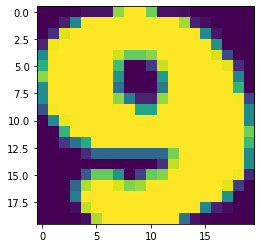

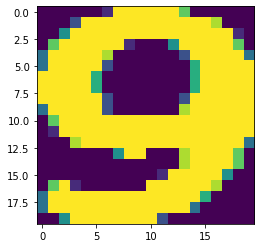

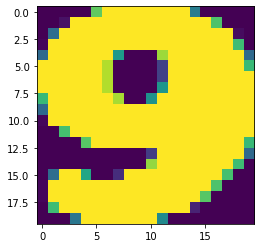

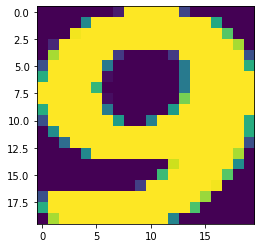

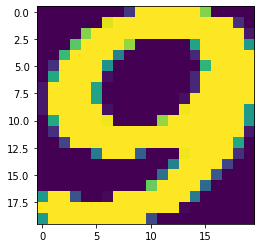

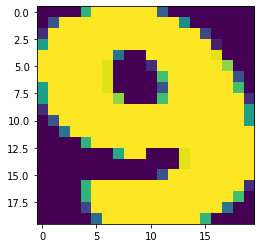

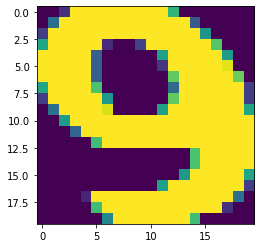

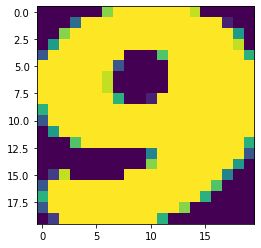

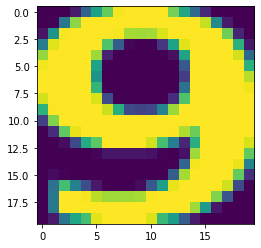

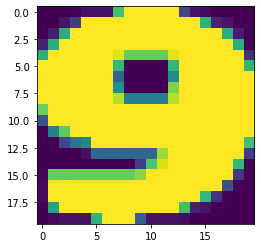

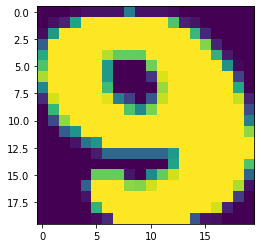

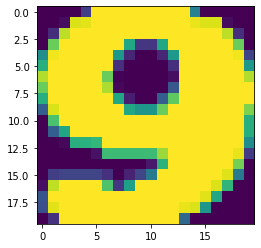

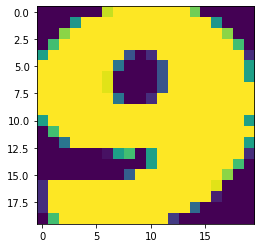

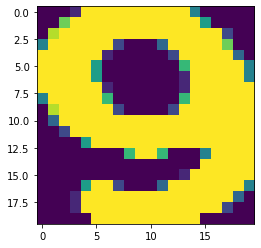

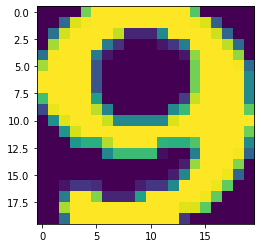

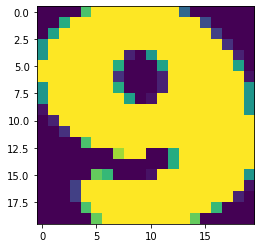

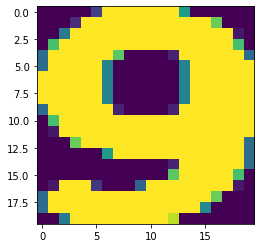

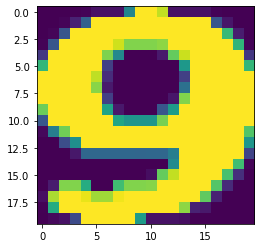

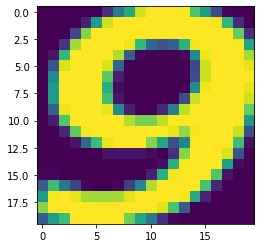

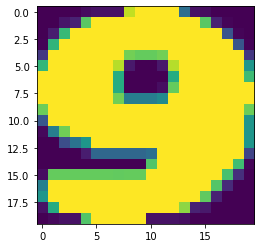

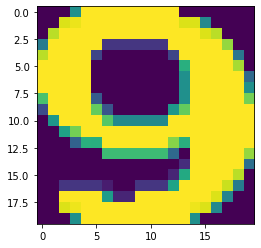

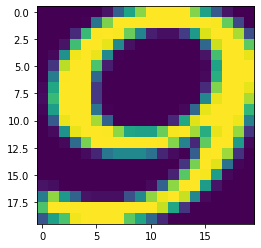

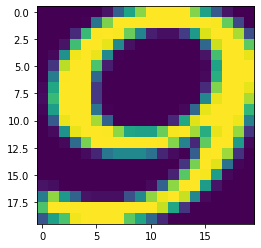

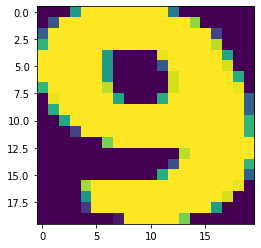

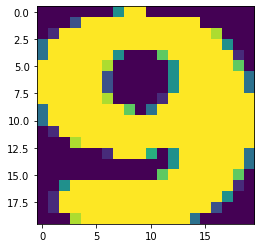

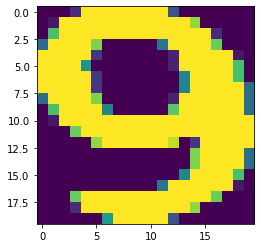

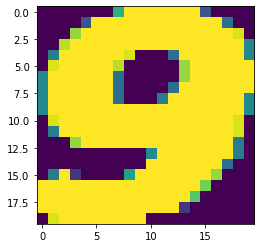

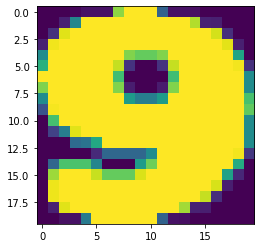

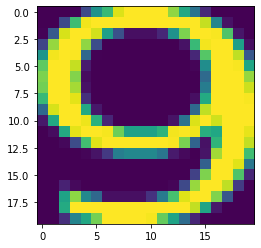

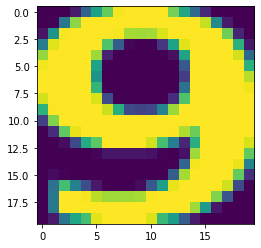

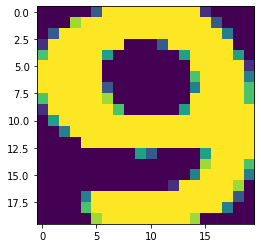

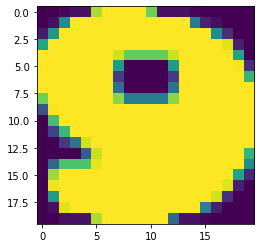

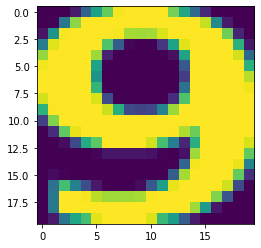

In [ ]:
#FUNCIÓN PARA PROBAR COSAS
# SE IRÁ DEL CÓDIGO EVENTUALMENTE

#Esta función en concreto busca todos los caracteres de un tipo en concreto
# y los dibuja

char_one = dfs[0].loc[:, 'm_label'] == 57
#chars = font_db.iloc[char_37, 12:]
chars = dfs[0][char_one]
for i in range(chars.shape[0]):
  chars2 = np.array(chars.iloc[i, 12:])
  chars3 = np.reshape(chars2, newshape=(20,20))
  plt.figure()
  plt.imshow(chars3.astype(float))
  plt.show()

### Building the GAN

In [14]:
##Right now, the generator only generates one image per execution,
## maybe it should be readapted to generate a BATCH of images

class Generator(nn.Module):
  def __init__(self, noise_dim=50, categorical_dim=10, categorical_noise_dim=30, image_size=20):
    super(Generator, self).__init__()

    self.noise_dim = noise_dim
    self.categorical_dim = categorical_dim
    self.categorical_noise_dim = categorical_noise_dim

    self.image_size = image_size #size of one of the sides of the image (we are working with square images)
    self.hidden_channels = 128 #channels of the first convolutional layer
    self.output_channels = 1 #the images we work with are black & white

    self.hidden_layer = self.hidden_channels * (self.image_size // 4) ** 2

    self.linear = nn.Linear(self.noise_dim + self.categorical_dim + self.categorical_noise_dim, self.hidden_layer)
    self.bn = nn.BatchNorm1d(self.hidden_layer)
    self.bn2 = nn.BatchNorm2d(self.hidden_channels//2)
    #self.upscale = F.upsample_bilinear(2)
    #self.upscale = nn.PixelShuffle(upscale_factor=2) # Better than F.upsample_bilinear: training GANs means avoiding sparse gradients
    self.conv1 = nn.Conv2d(self.hidden_channels, self.hidden_channels//2, (3,3), stride=1, padding=1)
    self.conv2 = nn.Conv2d(self.hidden_channels//2, self.output_channels, (3,3), stride=1, padding=1)


  def forward(self, z, cat, z_cat):
    x = self.bn(F.leaky_relu(self.linear(torch.cat((z, cat, z_cat), axis=1))))
    x = x.view(-1, self.hidden_channels, self.image_size // 4, self.image_size // 4)
    x = F.interpolate(x, scale_factor=2)
    #x = self.bn2(F.leaky_relu(self.conv1(self.upscale(x))))
    x = self.bn2(F.leaky_relu(self.conv1(x)))
    x = F.interpolate(x, scale_factor=2)
    x = F.tanh(self.conv2(x))

    return x
    
    #x = F.tanh(self.conv2(self.upscale(x)))

    #z = self.bn2(F.LeakyReLU(self.conv1(F.upsample_bilinear(z))))
    #z = F.tanh(self.conv2(F.upsample_bilinear(z)))
    
    
    #z = F.relu(F.upsample_bilinear(self.conv1(z)))
    #z = F.relu(F.upsample_bilinear(self.conv2(z)))


    # generate the noise that's going to be used for training
    #Z = torch.randn(n_noise, noise_size)
    #train_gen_data = DataLoader(Z, batch_size, shuffle=True, num_workers=2) #this code is useful to generate iterables

    #for e in range(epochs):
      #iterate through all batches
      #for batch in train_gen_data:
        #y = self(batch)
        #loss = self.criterion(y)
        #loss.backward()
        #self.optimizer.step()
        #self.optimizer.zero_grad()
    





In [15]:
class Discriminator(nn.Module):
  def __init__(self, noise_dim=50, categorical_dim=10, categorical_noise_dim=30, image_size=20):
    super(Discriminator, self).__init__()

    self.noise_dim = noise_dim
    self.categorical_dim = categorical_dim
    self.categorical_noise_dim = categorical_noise_dim

    self.image_size = image_size #size of one of the sides of the image (we are working with square images)
    self.hidden_channels = 128 #channels of the last convolutional layer
    self.input_channels = 1 #the images we work with are black & white

    self.hidden_layer = self.hidden_channels * (self.image_size // 4) ** 2

    self.conv1 = nn.Conv2d(self.input_channels, self.hidden_channels//2, (3,3), stride=1, padding=1)
    self.conv2 = nn.Conv2d(self.hidden_channels//2, self.hidden_channels, (3,3), stride=1, padding=1)

    self.bn = nn.BatchNorm2d(self.hidden_channels//2)
    self.bn2 = nn.BatchNorm2d(self.hidden_channels)
    self.avgpool = nn.AvgPool2d(kernel_size=2)
    self.flatten = nn.Flatten()

    self.true_dense = nn.Linear(self.hidden_layer, 1)
    self.cat_dense = nn.Linear(self.hidden_layer, self.categorical_dim)
    self.noise_dense = nn.Linear(self.hidden_layer, self.categorical_noise_dim)


  def forward(self, x):
    x = self.bn(self.avgpool(F.leaky_relu(self.conv1(x))))
    x = self.bn2(self.avgpool(F.leaky_relu(self.conv2(x))))
    x = self.flatten(x)
    true = F.sigmoid(self.true_dense(x))
    cat = F.softmax(self.cat_dense(x))
    cat_noise = self.noise_dense(x)

    return true, cat, cat_noise


  #Train of the discriminator
  #def discr_train(n_samples, n_epochs, batch_size, reset=False):

    #We generate the dataset that we're going to use to train
    #x_gen = self.generator(torch.randn((n_samples//2, self.generator.self.noise_size)))
    #Y = torch.zeros((batch_size//2, 1))
    #Y = torch.cat((Y, torch.ones((batch_size//2, 1))), dim=0)

    #We create a dataloader that fits our needs
    #data_real = random_shuffle(real_data)
    #data_real = data_real[:n_samples//2]
    #image_loader = DataLoader(data_real, batch_size=batch_size//2, shuffle=True, num_workers=2)

    #Training loop
    #for epoch in range(n_epochs):
      #for x_real in image_loader:
        #batch = torch.cat((batch, X_gen))
        #y_real = self(x_real)
        #y_gen = self(x_gen)
        #y_pred = self(batch)
        #loss = disc_loss(y_real, y_gen)
        #loss.backward()
        #self.optimizer.step()
        #self.optimizer.zero_grad()


In [16]:
#Generation of the different datasets that we're going to send to the generator
def generate_generator_data(batch_size, noise_dim=50, cat_dim=10, noise_cat_dim=30):

  noise = torch.normal(mean=0, std=1, size=(batch_size, noise_dim))

  #The categorical variable has to be one-hot encoded. This process does exactly that
  cat = torch.zeros(size=(batch_size, cat_dim))
  cat_vector = torch.randint(low=0, high=cat_dim, size=(batch_size,))
  for i in range(batch_size):
    cat[i, cat_vector[i]] = 1

  noise_cat = torch.normal(mean=0, std=1, size=(batch_size, noise_cat_dim))

  return noise, cat, noise_cat

In [17]:
# After defining the generator and discriminator classes, we define the rest of elements
# that are necessary for the training: loss functions and optimizers

lambda_cat = 1
lambda_con = 0.1

noise_dim = 50
cat_dim = 10
noise_cat_dim = 30

generator = Generator()
discriminator = Discriminator()

generator = generator.to(device)
discriminator = discriminator.to(device)

mse = nn.MSELoss()
cross_entropy = nn.CrossEntropyLoss()


# Functions for the calculation of the loss function
def rand_ones_like(tensor):
  return torch.rand_like(tensor)*0.3 + 0.9

def rand_zeros_like(tensor):
  return torch.rand_like(tensor)*0.3


# -- Definition for each of the losses
# Generator loss: MSE Loss
def gen_loss(pred):
  return mse(pred, rand_ones_like(pred))

# Discriminator loss: two batches of MSE loss: one for each batch (true images and )
def discr_loss(real_pred, fake_pred):
  real_loss = mse(real_pred, rand_ones_like(real_pred))
  fake_loss = mse(fake_pred, rand_zeros_like(fake_pred))
  return (real_loss + fake_loss) / 2

# Features loss: batch of noise and categories predicted by the discr.
#  noise is continuous (MSE loss) and categories are not (cross entropy loss)
def features_loss(cat_input, cat_pred, noise_input, noise_pred):
  return lambda_cat * cross_entropy(cat_input, torch.argmax(cat_pred, axis=1)) + lambda_con * mse(noise_input, noise_pred)


gen_optim = torch.optim.Adam(generator.parameters(), lr=0.001)
discr_optim = torch.optim.SGD(discriminator.parameters(), lr=0.001)
features_optim = torch.optim.Adam(chain(generator.parameters(), discriminator.parameters()))

In [ ]:
numbers_loader.dataset[0]

KeyError: ignored

In [ ]:
real_img_batch.type()

'torch.cuda.DoubleTensor'

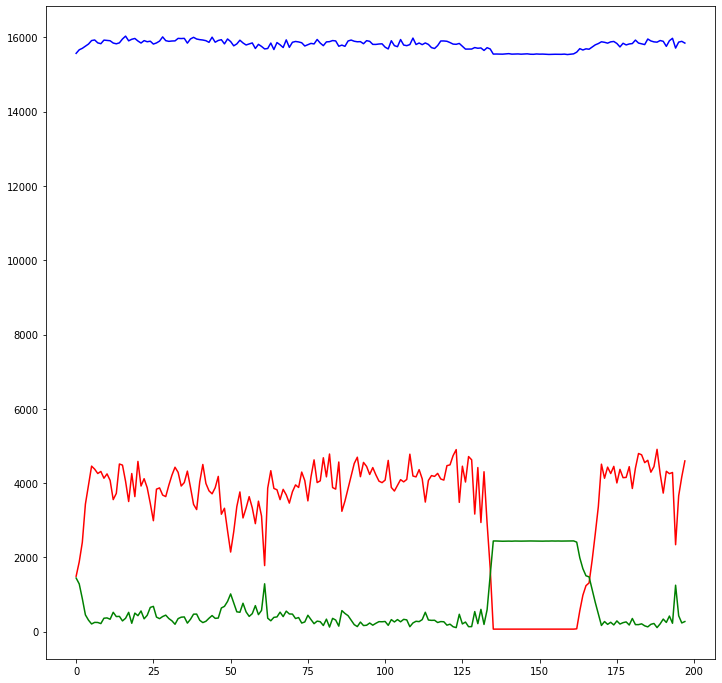

Train Epoch: 199/5000 [0/210229 (0.0%)]
Train Epoch: 199/5000 [3200/210229 (1.5%)]
Train Epoch: 199/5000 [6400/210229 (3.0%)]
Train Epoch: 199/5000 [9600/210229 (4.6%)]
Train Epoch: 199/5000 [12800/210229 (6.1%)]
Train Epoch: 199/5000 [16000/210229 (7.6%)]
Train Epoch: 199/5000 [19200/210229 (9.1%)]
Train Epoch: 199/5000 [22400/210229 (10.7%)]
Train Epoch: 199/5000 [25600/210229 (12.2%)]
Train Epoch: 199/5000 [28800/210229 (13.7%)]
Train Epoch: 199/5000 [32000/210229 (15.2%)]
Train Epoch: 199/5000 [35200/210229 (16.7%)]
Train Epoch: 199/5000 [38400/210229 (18.3%)]
Train Epoch: 199/5000 [41600/210229 (19.8%)]
Train Epoch: 199/5000 [44800/210229 (21.3%)]
Train Epoch: 199/5000 [48000/210229 (22.8%)]
Train Epoch: 199/5000 [51200/210229 (24.4%)]
Train Epoch: 199/5000 [54400/210229 (25.9%)]
Train Epoch: 199/5000 [57600/210229 (27.4%)]
Train Epoch: 199/5000 [60800/210229 (28.9%)]
Train Epoch: 199/5000 [64000/210229 (30.4%)]
Train Epoch: 199/5000 [67200/210229 (32.0%)]
Train Epoch: 199/5000 [7

In [ ]:
from IPython.display import clear_output

# --------
# TRAINING
# --------

n_epochs = 5000
dataloader = numbers_loader

# We set up these variables that are designed for plotting
gen_loss_acum = []
discr_loss_acum = []
features_loss_acum = []

# This training is only performed on the numbers dataset

for epoch in range(n_epochs):

  gen_loss_epoch = 0
  discr_loss_epoch = 0
  features_loss_epoch = 0

  for batch_idx, (real_img_batch, real_img_label) in enumerate(dataloader):

    real_img_batch = real_img_batch.to(device)
    #real_img_real_img_batch.type(torch.cuda.FloatTensor)

    ## ------------------
    ## GENERATOR TRAINING
    ## ------------------

    gen_optim.zero_grad()
    noise, cat, noise_cat = generate_generator_data(batch_size, noise_dim, cat_dim, noise_cat_dim)
    noise, cat, noise_cat = noise.to(device), cat.to(device), noise_cat.to(device)
    img_batch = generator(noise, cat, noise_cat)
    img_batch = img_batch.to(device)
    veracity, _, _ = discriminator(img_batch)
    generator_loss = gen_loss(veracity)
    generator_loss.backward()
    gen_optim.step()


    ## ----------------------
    ## DISCRIMINATOR TRAINING
    ## ----------------------

    discr_optim.zero_grad()

    # First, we send a batch that has been created from the generator
    noise, cat, noise_cat = generate_generator_data(batch_size, noise_dim, cat_dim, noise_cat_dim)
    noise, cat, noise_cat = noise.to(device), cat.to(device), noise_cat.to(device)
    img_batch = generator(noise, cat, noise_cat).detach()
    img_batch = img_batch.to(device)
    veracity_gen, _, _ = discriminator(img_batch)

    # Then, we send a batch from the real images
    veracity_real, _, _ = discriminator(real_img_batch.type(torch.cuda.FloatTensor))

    # We calculate the loss and apply backpropagation
    discriminator_loss = discr_loss(veracity_real, veracity_gen)
    discriminator_loss.backward()
    discr_optim.step()


    ## ----------------
    ## FEATURE TRAINING
    ## ----------------

    features_optim.zero_grad()

    noise, cat, noise_cat = generate_generator_data(batch_size, noise_dim, cat_dim, noise_cat_dim)
    noise, cat, noise_cat = noise.to(device), cat.to(device), noise_cat.to(device)
    img_batch = generator(noise, cat, noise_cat)
    img_batch = img_batch.to(device)
    _, cat_pred, noise_cat_pred = discriminator(img_batch)
    loss = features_loss(cat, cat_pred, noise_cat, noise_cat_pred)
    loss.backward()
    features_optim.step()

    gen_loss_epoch = gen_loss_epoch + generator_loss
    discr_loss_epoch = discr_loss_epoch + discriminator_loss
    features_loss_epoch = features_loss_epoch + loss

    #END OF BATCH TEXT
    if batch_idx % 100 == 0:
      print(
          f'Train Epoch: {epoch+1}/{n_epochs} [{batch_idx*len(real_img_batch)}/{len(dataloader.dataset)} ({round(100. * batch_idx / len(dataloader), 1)}%)]')

  #with torch.no_grad():
  gen_loss_acum.append(gen_loss_epoch.detach())
  discr_loss_acum.append(discr_loss_epoch.detach())
  features_loss_acum.append(features_loss_epoch.detach())

  clear_output(wait=True)
  plt.figure(figsize=(12,12))
  plt.plot(gen_loss_acum, 'r')
  plt.plot(discr_loss_acum, 'g')
  plt.plot(features_loss_acum, 'b')
  plt.show()
  

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


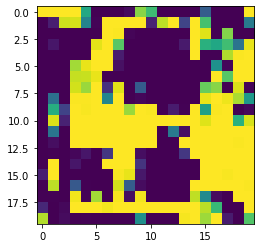

In [ ]:
noise, cat, noise_cat = generate_generator_data(2)
noise, cat, noise_cat = noise.to(device), cat.to(device), noise_cat.to(device)
img_batch = generator(noise, cat, noise_cat)
plt.imshow(img_batch[0,0,:,:].cpu().detach().numpy())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use tor

Train Epoch: 1/5 [0/210229 (0.0%)]
Train Epoch: 1/5 [3200/210229 (1.5%)]
Train Epoch: 1/5 [6400/210229 (3.0%)]
Train Epoch: 1/5 [9600/210229 (4.6%)]
Train Epoch: 1/5 [12800/210229 (6.1%)]
Train Epoch: 1/5 [16000/210229 (7.6%)]
Train Epoch: 1/5 [19200/210229 (9.1%)]
Train Epoch: 1/5 [22400/210229 (10.7%)]
Train Epoch: 1/5 [25600/210229 (12.2%)]
Train Epoch: 1/5 [28800/210229 (13.7%)]
Train Epoch: 1/5 [32000/210229 (15.2%)]
Train Epoch: 1/5 [35200/210229 (16.7%)]
Train Epoch: 1/5 [38400/210229 (18.3%)]
Train Epoch: 1/5 [41600/210229 (19.8%)]
Train Epoch: 1/5 [44800/210229 (21.3%)]
Train Epoch: 1/5 [48000/210229 (22.8%)]
Train Epoch: 1/5 [51200/210229 (24.4%)]
Train Epoch: 1/5 [54400/210229 (25.9%)]
Train Epoch: 1/5 [57600/210229 (27.4%)]
Train Epoch: 1/5 [60800/210229 (28.9%)]
Train Epoch: 1/5 [64000/210229 (30.4%)]
Train Epoch: 1/5 [67200/210229 (32.0%)]
Train Epoch: 1/5 [70400/210229 (33.5%)]
Train Epoch: 1/5 [73600/210229 (35.0%)]
Train Epoch: 1/5 [76800/210229 (36.5%)]
Train Epoch: 1

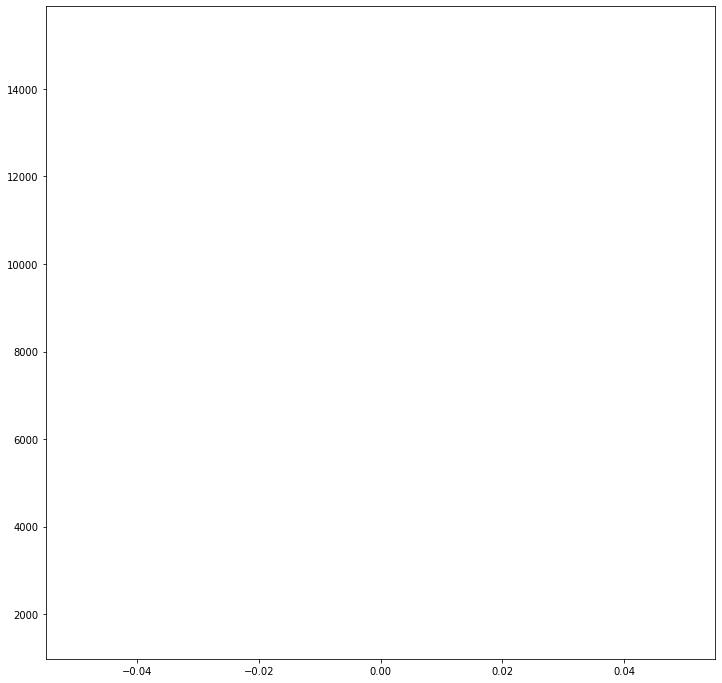

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


Train Epoch: 2/5 [0/210229 (0.0%)]
Train Epoch: 2/5 [3200/210229 (1.5%)]
Train Epoch: 2/5 [6400/210229 (3.0%)]
Train Epoch: 2/5 [9600/210229 (4.6%)]
Train Epoch: 2/5 [12800/210229 (6.1%)]
Train Epoch: 2/5 [16000/210229 (7.6%)]
Train Epoch: 2/5 [19200/210229 (9.1%)]
Train Epoch: 2/5 [22400/210229 (10.7%)]
Train Epoch: 2/5 [25600/210229 (12.2%)]
Train Epoch: 2/5 [28800/210229 (13.7%)]
Train Epoch: 2/5 [32000/210229 (15.2%)]
Train Epoch: 2/5 [35200/210229 (16.7%)]
Train Epoch: 2/5 [38400/210229 (18.3%)]
Train Epoch: 2/5 [41600/210229 (19.8%)]
Train Epoch: 2/5 [44800/210229 (21.3%)]
Train Epoch: 2/5 [48000/210229 (22.8%)]
Train Epoch: 2/5 [51200/210229 (24.4%)]
Train Epoch: 2/5 [54400/210229 (25.9%)]
Train Epoch: 2/5 [57600/210229 (27.4%)]
Train Epoch: 2/5 [60800/210229 (28.9%)]
Train Epoch: 2/5 [64000/210229 (30.4%)]
Train Epoch: 2/5 [67200/210229 (32.0%)]
Train Epoch: 2/5 [70400/210229 (33.5%)]
Train Epoch: 2/5 [73600/210229 (35.0%)]
Train Epoch: 2/5 [76800/210229 (36.5%)]
Train Epoch: 2

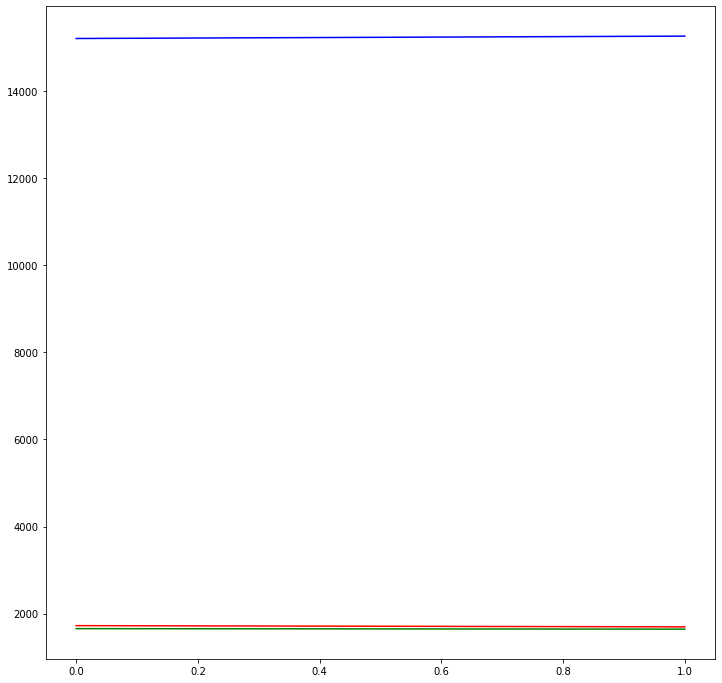

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


Train Epoch: 3/5 [0/210229 (0.0%)]
Train Epoch: 3/5 [3200/210229 (1.5%)]
Train Epoch: 3/5 [6400/210229 (3.0%)]
Train Epoch: 3/5 [9600/210229 (4.6%)]
Train Epoch: 3/5 [12800/210229 (6.1%)]
Train Epoch: 3/5 [16000/210229 (7.6%)]
Train Epoch: 3/5 [19200/210229 (9.1%)]
Train Epoch: 3/5 [22400/210229 (10.7%)]
Train Epoch: 3/5 [25600/210229 (12.2%)]
Train Epoch: 3/5 [28800/210229 (13.7%)]
Train Epoch: 3/5 [32000/210229 (15.2%)]
Train Epoch: 3/5 [35200/210229 (16.7%)]
Train Epoch: 3/5 [38400/210229 (18.3%)]
Train Epoch: 3/5 [41600/210229 (19.8%)]
Train Epoch: 3/5 [44800/210229 (21.3%)]
Train Epoch: 3/5 [48000/210229 (22.8%)]
Train Epoch: 3/5 [51200/210229 (24.4%)]
Train Epoch: 3/5 [54400/210229 (25.9%)]
Train Epoch: 3/5 [57600/210229 (27.4%)]
Train Epoch: 3/5 [60800/210229 (28.9%)]
Train Epoch: 3/5 [64000/210229 (30.4%)]
Train Epoch: 3/5 [67200/210229 (32.0%)]
Train Epoch: 3/5 [70400/210229 (33.5%)]
Train Epoch: 3/5 [73600/210229 (35.0%)]
Train Epoch: 3/5 [76800/210229 (36.5%)]
Train Epoch: 3

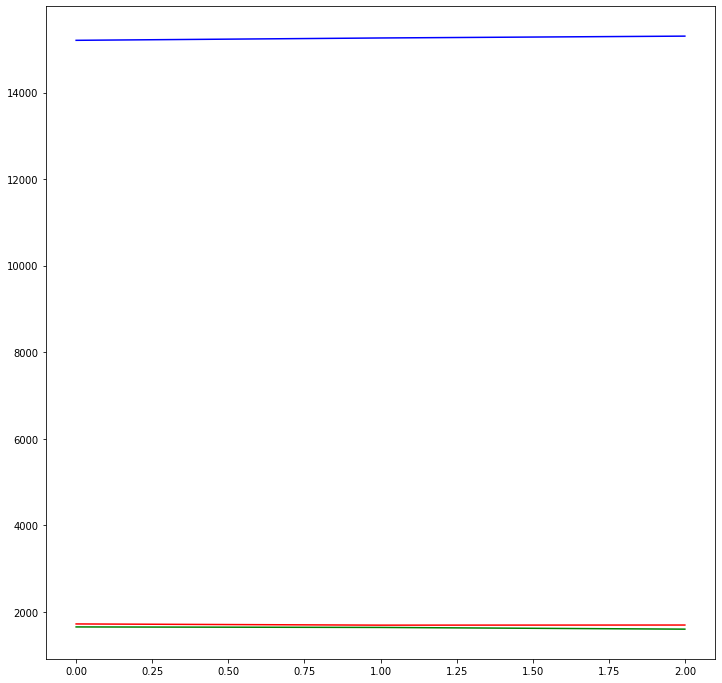

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


Train Epoch: 4/5 [0/210229 (0.0%)]
Train Epoch: 4/5 [3200/210229 (1.5%)]
Train Epoch: 4/5 [6400/210229 (3.0%)]
Train Epoch: 4/5 [9600/210229 (4.6%)]
Train Epoch: 4/5 [12800/210229 (6.1%)]
Train Epoch: 4/5 [16000/210229 (7.6%)]
Train Epoch: 4/5 [19200/210229 (9.1%)]
Train Epoch: 4/5 [22400/210229 (10.7%)]
Train Epoch: 4/5 [25600/210229 (12.2%)]
Train Epoch: 4/5 [28800/210229 (13.7%)]
Train Epoch: 4/5 [32000/210229 (15.2%)]
Train Epoch: 4/5 [35200/210229 (16.7%)]
Train Epoch: 4/5 [38400/210229 (18.3%)]
Train Epoch: 4/5 [41600/210229 (19.8%)]
Train Epoch: 4/5 [44800/210229 (21.3%)]
Train Epoch: 4/5 [48000/210229 (22.8%)]
Train Epoch: 4/5 [51200/210229 (24.4%)]
Train Epoch: 4/5 [54400/210229 (25.9%)]
Train Epoch: 4/5 [57600/210229 (27.4%)]
Train Epoch: 4/5 [60800/210229 (28.9%)]
Train Epoch: 4/5 [64000/210229 (30.4%)]
Train Epoch: 4/5 [67200/210229 (32.0%)]
Train Epoch: 4/5 [70400/210229 (33.5%)]
Train Epoch: 4/5 [73600/210229 (35.0%)]
Train Epoch: 4/5 [76800/210229 (36.5%)]
Train Epoch: 4

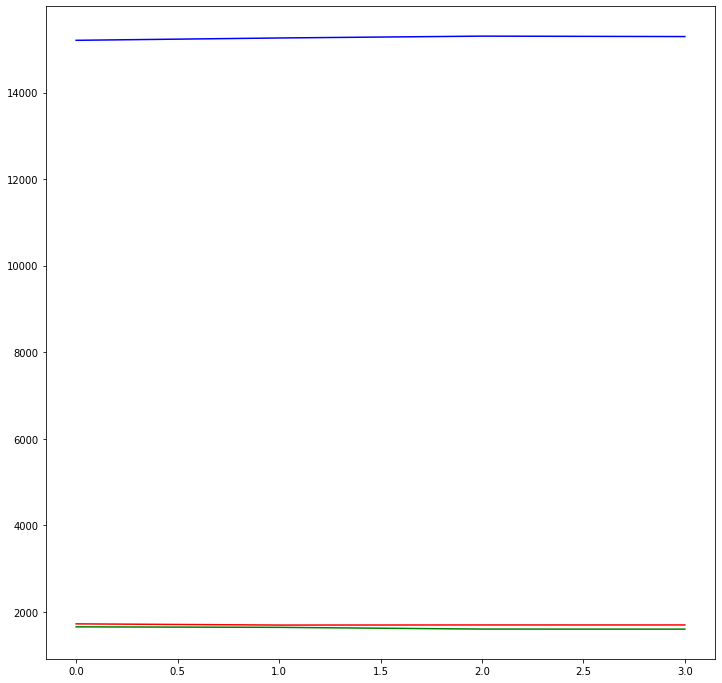

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


Train Epoch: 5/5 [0/210229 (0.0%)]
Train Epoch: 5/5 [3200/210229 (1.5%)]
Train Epoch: 5/5 [6400/210229 (3.0%)]
Train Epoch: 5/5 [9600/210229 (4.6%)]
Train Epoch: 5/5 [12800/210229 (6.1%)]
Train Epoch: 5/5 [16000/210229 (7.6%)]
Train Epoch: 5/5 [19200/210229 (9.1%)]
Train Epoch: 5/5 [22400/210229 (10.7%)]
Train Epoch: 5/5 [25600/210229 (12.2%)]
Train Epoch: 5/5 [28800/210229 (13.7%)]
Train Epoch: 5/5 [32000/210229 (15.2%)]
Train Epoch: 5/5 [35200/210229 (16.7%)]
Train Epoch: 5/5 [38400/210229 (18.3%)]
Train Epoch: 5/5 [41600/210229 (19.8%)]
Train Epoch: 5/5 [44800/210229 (21.3%)]
Train Epoch: 5/5 [48000/210229 (22.8%)]
Train Epoch: 5/5 [51200/210229 (24.4%)]
Train Epoch: 5/5 [54400/210229 (25.9%)]
Train Epoch: 5/5 [57600/210229 (27.4%)]
Train Epoch: 5/5 [60800/210229 (28.9%)]
Train Epoch: 5/5 [64000/210229 (30.4%)]
Train Epoch: 5/5 [67200/210229 (32.0%)]
Train Epoch: 5/5 [70400/210229 (33.5%)]
Train Epoch: 5/5 [73600/210229 (35.0%)]
Train Epoch: 5/5 [76800/210229 (36.5%)]
Train Epoch: 5

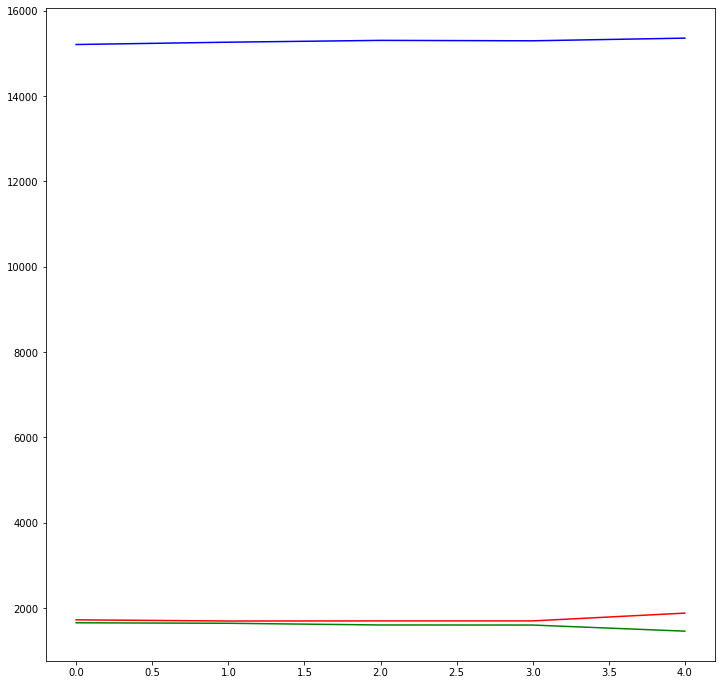

In [ ]:
# --------
# TRAINING
# --------

n_epochs = 5
dataloader = numbers_loader

# We set up these variables that are designed for plotting
gen_loss_acum = []
discr_loss_acum = []
features_loss_acum = []

# This training is only performed on the numbers dataset

for epoch in range(n_epochs):

  gen_loss_epoch = 0
  discr_loss_epoch = 0
  features_loss_epoch = 0

  for batch_idx, (real_img_batch, real_img_label) in enumerate(dataloader):

    real_img_batch = real_img_batch.to(device)

    ## ------------------
    ## GENERATOR TRAINING
    ## ------------------

    gen_optim.zero_grad()
    noise, cat, noise_cat = generate_generator_data(batch_size, noise_dim, cat_dim, noise_cat_dim)
    noise, cat, noise_cat = noise.to(device), cat.to(device), noise_cat.to(device)
    img_batch = generator(noise, cat, noise_cat)
    img_batch = img_batch.to(device)
    veracity, _, _ = discriminator(img_batch)
    generator_loss = gen_loss(veracity)
    generator_loss.backward()
    gen_optim.step()


    ## ----------------------
    ## DISCRIMINATOR TRAINING
    ## ----------------------

    discr_optim.zero_grad()

    # First, we send a batch that has been created from the generator
    noise, cat, noise_cat = generate_generator_data(batch_size, noise_dim, cat_dim, noise_cat_dim)
    noise, cat, noise_cat = noise.to(device), cat.to(device), noise_cat.to(device)
    img_batch = generator(noise, cat, noise_cat)
    img_batch = img_batch.to(device)
    veracity_gen, _, _ = discriminator(img_batch)

    # Then, we send a batch from the real images
    veracity_real, _, _ = discriminator(real_img_batch)

    # We calculate the loss and apply backpropagation
    discriminator_loss = discr_loss(veracity_real, veracity_gen)
    discriminator_loss.backward()
    discr_optim.step()


    ## ----------------
    ## FEATURE TRAINING
    ## ----------------

    features_optim.zero_grad()

    noise, cat, noise_cat = generate_generator_data(batch_size, noise_dim, cat_dim, noise_cat_dim)
    noise, cat, noise_cat = noise.to(device), cat.to(device), noise_cat.to(device)
    img_batch = generator(noise, cat, noise_cat)
    img_batch = img_batch.to(device)
    _, cat_pred, noise_cat_pred = discriminator(img_batch)
    loss = features_loss(cat, cat_pred, noise_cat, noise_cat_pred)
    loss.backward()
    features_optim.step()

    gen_loss_epoch = gen_loss_epoch + generator_loss
    discr_loss_epoch = discr_loss_epoch + discriminator_loss
    features_loss_epoch = features_loss_epoch + loss

    #END OF BATCH TEXT
    if batch_idx % 100 == 0:
      print(
          f'Train Epoch: {epoch+1}/{n_epochs} [{batch_idx*len(real_img_batch)}/{len(dataloader.dataset)} ({round(100. * batch_idx / len(dataloader), 1)}%)]')

  gen_loss_acum.append(gen_loss_epoch)
  discr_loss_acum.append(discr_loss_epoch)
  features_loss_acum.append(features_loss_epoch)

  plt.figure(figsize=(12,12))
  plt.plot(gen_loss_acum, 'r')
  plt.plot(discr_loss_acum, 'g')
  plt.plot(features_loss_acum, 'b')
  plt.show()
  